Imports

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data

from src.data.load_data import load_data

Loading in the processed data with custom function

In [3]:
target = "log_ClaimRate"

(X_train, y_train), (X_test, y_test)= load_data(raw=False, target=target)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

We fit a PCA model on the training feature matrix to analyze how many principal components are needed to keep a certain amount of variance explained. It:
- Runs PCA with up to `n_features - 1` components.  
- Computes the cumulative sum of explained variance.  
- Plots the cumulative explained variance against the number of components.  
- Returns the reducer, the cumulative curve, and the smallest number of components needed to reach the target cumulative variance.

In [4]:
def elbow_on_train(X_train: int, randomized: bool, seed: int, target: float):
    reducer = PCA(
        n_components=X_train.shape[1]-1,
        svd_solver="randomized",
        iterated_power=7 if randomized else "auto",
        random_state=seed
    )
    
    reducer.fit(X_train)
    evr = reducer.explained_variance_ratio_
    cum = np.cumsum(evr)
    
    plt.figure()
    plt.plot(np.arange(1, len(cum)+1), cum, marker="o")
    plt.xlabel("k components")
    plt.ylabel("Cumulative explained variance")
    plt.title(("PCA") + " Elbow (train only)")
    plt.grid(True)
    plt.show()

    return reducer, cum, int(np.searchsorted(cum, target) + 1)

We then run the full preprocessing and PCA dimensionality-reduction pipeline:
- Compute k.  
- Refit PCA with the obtained k and create the transormed data.
- We print the kept varianec kept.

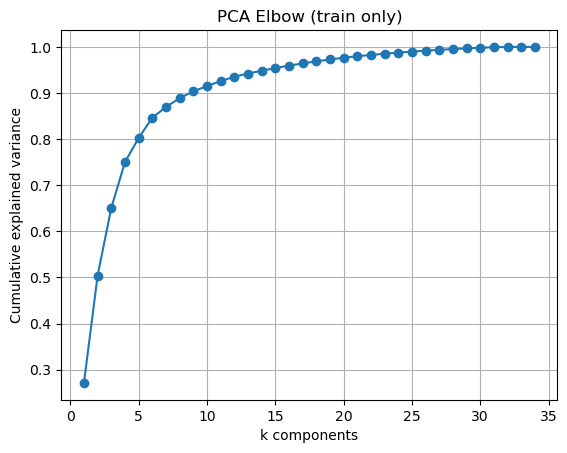

Z_train shape: (542410, 9) Z_test shape: (135603, 9)
Cumulative variance kept: 0.9034946916550902


In [5]:
probe, cum, k = elbow_on_train(X_train, True, 42, 0.9)
reducer = PCA(n_components=k, svd_solver="randomized", iterated_power=7, random_state=42)

Z_train = reducer.fit_transform(X_train)
Z_test = reducer.transform(X_test)

evr_final = reducer.explained_variance_ratio_
print("Z_train shape:", Z_train.shape, "Z_test shape:", Z_test.shape)
print("Cumulative variance kept:", float(np.cumsum(evr_final)[-1]))

Defining a function to visualize the PCA-reduced data in 2D using the first two principal components.
Create the coloring with the use of the target.

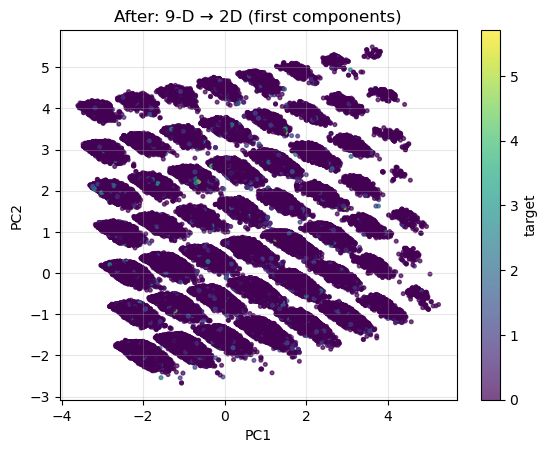

In [6]:
def plot_2d_from_pca(Z, y, title="After PCA (first 2 comps)"):
    plt.figure()
    sc = plt.scatter(Z[:, 0], Z[:, 1], c=y, s=7, alpha=0.7)
    plt.colorbar(sc, label="target")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_2d_from_pca(Z_train, y_train, title=f"After: {k}-D → 2D (first components)")

> Clustering

Estimates a suitable number of clusters for KMeans by scanning over different `k` values on a subsampled PCA space:
- Subsample the data for computational efficiency.
- For each `k` in `[k_min, k_max]`, fits a KMeans model, records its inertia, and computes the silhouette score on the subsample.  
- Plots both the inertia curve and the silhouette curve side by side to help choose an appropriate number of clusters.

In [7]:
def find_best_k(Z_train, k_min=2, k_max=15, random_state=42, max_samples=20000):
    rng = np.random.default_rng(random_state)
    if Z_train.shape[0] > max_samples:
        idx = rng.choice(Z_train.shape[0], size=max_samples, replace=False)
        Z_sub = Z_train[idx]
    else:
        Z_sub = Z_train

    inertias = []
    silhouettes = []

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
        labels_sub = km.fit_predict(Z_sub)

        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(Z_sub, labels_sub))

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(k_min, k_max+1), inertias, marker='o')
    plt.title("KMeans inertia (elbow)")
    plt.xlabel("k"); plt.ylabel("Inertia")

    plt.subplot(1,2,2)
    plt.plot(range(k_min, k_max+1), silhouettes, marker='o')
    plt.title("Silhouette score (subsample)")
    plt.xlabel("k"); plt.ylabel("Silhouette")

    plt.tight_layout()
    plt.show()

    return inertias, silhouettes

In [8]:
inertias, silhouettes = find_best_k(Z_train)

KeyboardInterrupt: 

Choosed a fixed number of clusters (`k_best = 5`) for KMeans based on prior inspection of the inertia and silhouette curves, then:
- Fitted a KMeans model with 5 clusters on the full PCA-reduced training data `Z_train`.  
- Used the fitted model to assign cluster labels to both the training set (`cluster_train`) and the test set (`cluster_test`).

In [10]:
# k_best = np.argmax(silhouettes) + 2
k_best = 5
kmeans = KMeans(n_clusters=k_best, n_init="auto", random_state=42)
cluster_train = kmeans.fit_predict(Z_train)
cluster_test  = kmeans.predict(Z_test)

Visualizes the KMeans clusters in two PCA dimensions:
- Uses `Z_train` from before.
- Uses the precomputed cluster labels `cluster_train` to color the points in this 2D projection.  
- Produces a scatter plot where each point’s position comes from the 2D PCA projection.

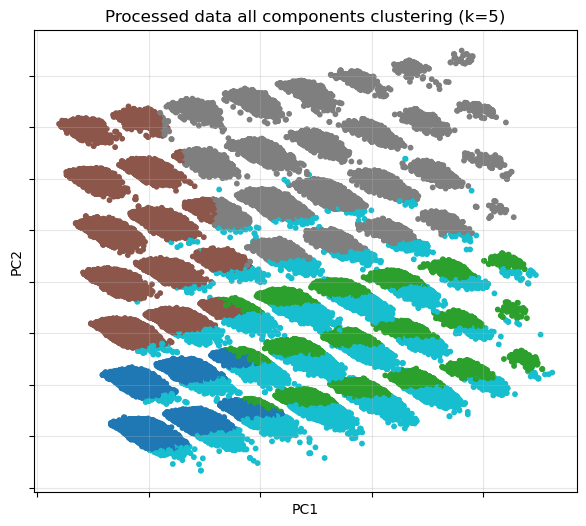

In [12]:
viz_pca = PCA(n_components=2, random_state=42)
proj_2d = viz_pca.fit_transform(Z_train)

plt.figure(figsize=(7,6))
sc = plt.scatter(proj_2d[:,0], proj_2d[:,1], c=cluster_train, cmap="tab10", s=10)
plt.title(f"Processed data all components clustering (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax = plt.gca()
ax.tick_params(labelbottom=False, labelleft=False)

plt.grid(True, alpha=0.3)
plt.show();

Performs KMeans clustering directly in a 2D PCA projection for an intuitive plot:  
- We use the Z_train from before again. 
- Fits a KMeans model with `k` clusters on `Z_train` and obtains cluster labels (`labels`) in this exact 2D space.
- Creates a scatter plot of the 2D PCA coordinates colored by these KMeans labels, showing cluster assignments that correspond directly to the visible point cloud.

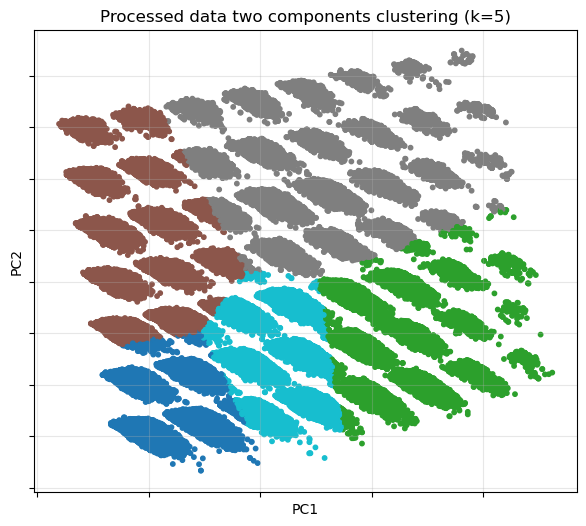

In [11]:
viz_pca = PCA(n_components=2, random_state=42)
Z2 = viz_pca.fit_transform(Z_train)

plt.figure(figsize=(7,6))
labels = KMeans(n_clusters=k_best, n_init="auto", random_state=42).fit_predict(Z2)
sc = plt.scatter(Z2[:,0], Z2[:,1], c=labels, cmap="tab10", s=10)
plt.title(f"Processed data two components clustering (k={k_best})")
plt.xlabel("PC1")
plt.ylabel("PC2")
ax = plt.gca()
ax.tick_params(labelbottom=False, labelleft=False)

plt.grid(True, alpha=0.3)
plt.show();